In [1]:
import numpy as np
import pandas as pd
from Finanzen.Portfolio import Portfolio
import Finanzen.Tools as tl

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib

# Define Portfolio and weights

In [2]:
a = ['AMZN', 'GOOG', 'WMT', 'TSLA', 'META']
weights = [2.5, 1, 1, 1, 1]

weighted_assets = tl.lists2dict(a, weights)

P = Portfolio(assets=weighted_assets)
print(P.returns)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed

Ticker          AMZN      GOOG      META      TSLA       WMT
Date                                                        
2023-11-16 -0.369995  2.319992  1.478424 -9.250000 -4.547562
2023-11-17  2.349991 -1.759995  0.849121  0.710007 -0.228374
2023-11-20  0.950012  0.979996  4.924774  1.300003 -0.016548
2023-11-21 -2.230011  0.699997 -2.986816  5.599991  0.185349
2023-11-22  2.810013  1.400009  4.505188 -6.989990 -0.393860
...              ...       ...       ...       ...       ...
2024-05-08 -0.759995 -1.819992  4.360016 -3.089996 -0.320000
2024-05-09  1.500000  0.419998  2.820007 -2.750000  0.139999
2024-05-10 -2.020004 -1.290009  0.779999 -3.500000  0.040001
2024-05-13 -0.909988  0.610001 -8.190002  3.419998 -0.070000
2024-05-14  0.500000  1.029999  3.839996  5.660004 -0.549999

[123 rows x 5 columns]


# Plot portfolio statistics

<Axes: xlabel='Time', ylabel='Returns'>

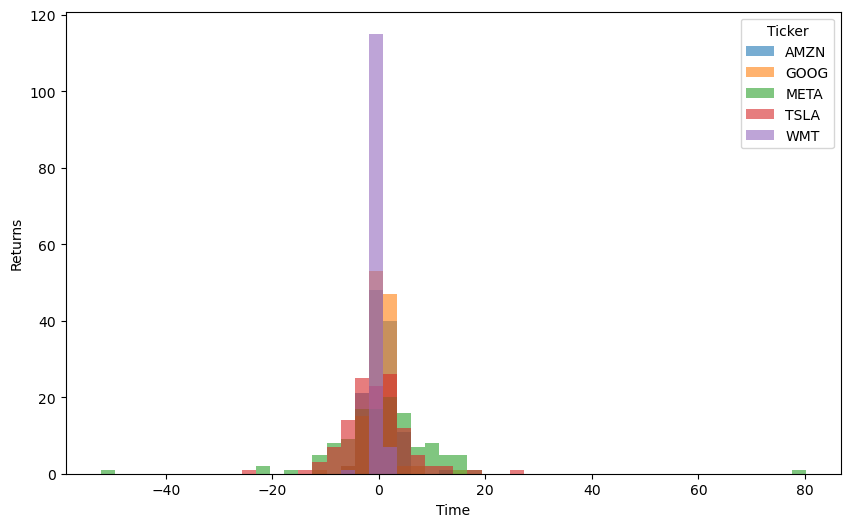

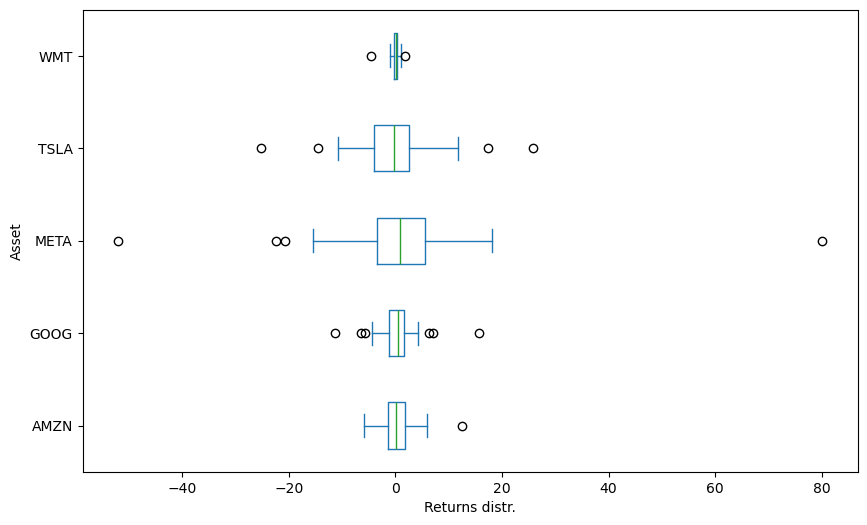

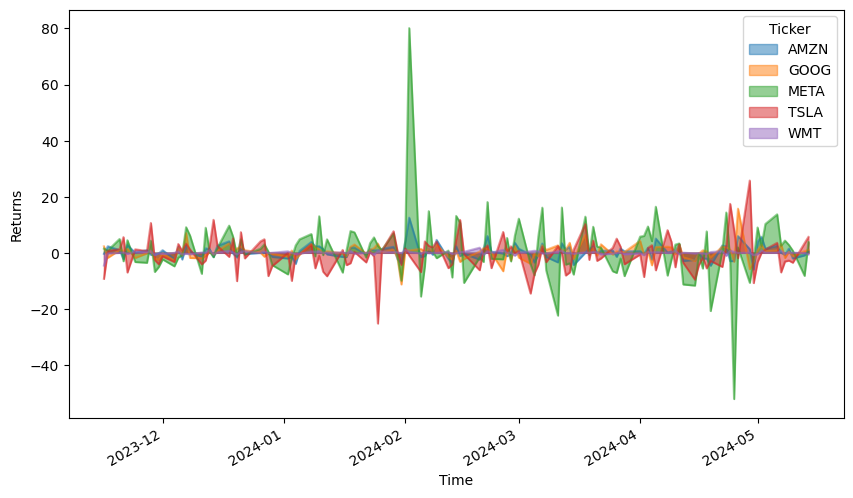

In [3]:
df = P.returns

#df.plot(kind="bar", figsize=(10,6), ylabel="Returns", xlabel="Time", subplots=False)
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,6), ylabel="Returns", xlabel="Time")
df.plot(kind="box",vert=False , figsize=(10,6), ylabel="Asset", xlabel="Returns distr.")
df.plot(kind="area", stacked=False, figsize=(10,6), ylabel="Returns", xlabel="Time")



In [ ]:
#ax = P.returns.plot(kind="bar", figsize=(10, 6))
#ax.set_xlabel('Time')
#ax.legend(ncol=5)
#ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
#ax.xaxis.set_major_formatter(
#    matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%b'))
#plt.show()

# Basic statistics of the portfolio

In [7]:
pprint(P.total_prices())

Ticker            AMZN        GOOG        META        TSLA        WMT  \
Date                                                                    
2023-11-14  145.800003  135.429993  335.953552  237.410004  55.487564   
2023-11-15  143.199997  136.380005  332.357361  242.839996  56.192543   
2023-11-16  142.830002  138.699997  333.835785  233.589996  51.644974   
2023-11-17  145.179993  136.940002  334.684906  234.300003  51.416603   
2023-11-20  146.130005  137.919998  339.609680  235.600006  51.400055   
...                ...         ...         ...         ...        ...   
2024-05-07  188.759995  172.979996  468.239990  177.809998  60.619999   
2024-05-08  188.000000  171.160004  472.600006  174.720001  60.299999   
2024-05-09  189.500000  171.580002  475.420013  171.970001  60.439999   
2024-05-10  187.479996  170.289993  476.200012  168.470001  60.480000   
2024-05-13  186.570007  170.899994  468.010010  171.889999  60.410000   

Ticker      AMZN_total  GOOG_total  WMT_total  TSL

In [4]:
# Variance of Portfolio return
sigma = P.correlation_matrix(True)
w = P.weight_vector()
sigma_total = np.matmul(np.matmul(w, sigma), w.T)

print(w, sigma_total, type(sigma))

[0.38461538 0.15384615 0.15384615 0.15384615 0.15384615] 0.4215914772209518 <class 'numpy.ndarray'>


In [5]:
df = pd.concat([P.expected_return(), P.excpected_risk()], axis=1)
df.columns=["Expected Return", "Risk"]
df

,Expected Return,Risk
Ticker,,
AMZN,0.356667,6.455365
GOOG,0.289024,7.510778
META,1.134087,128.899993
TSLA,-0.530813,37.646786
WMT,0.029817,0.399654


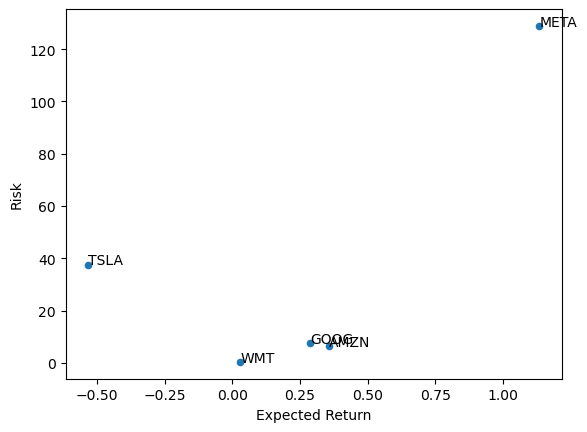

In [6]:
fig, ax = plt.subplots()
df.plot("Expected Return", "Risk", kind="scatter", ax=ax)

for k, v in df.iterrows():
    ax.annotate(k, v)

# Minimum Portfolios by matrix inversion

## Global minimum
This finds the global minimum without optimizing an expected return.

In [12]:
from scipy.linalg import inv
import numpy as np

S2 = np.vstack((2. * sigma, np.ones((1, sigma.shape[0]))))
S2 = np.hstack((S2, np.ones((sigma.shape[0]+1, 1))))
S2[-1, -1] = 0.

unit_vec = np.zeros((sigma.shape[0]+1, 1))
unit_vec[-1, 0] = 1.
np.dot(inv(S2), unit_vec)[:-1]

array([[-0.07098607],
       [ 0.27700386],
       [ 0.25610147],
       [ 0.26915392],
       [ 0.26872682]])

## Minimum variance portfolio
This finds the minimum variance portfolio given an expected return.

In [13]:
# stack weight vector on the right
S2 = np.hstack((2. * sigma, P.weight_vector().reshape((P.size, 1))))

# stack weight vector below. Define elongated weight vecor first.
wt = np.append(P.weight_vector(), np.zeros((1, 1)))
S2 = np.vstack((S2, wt))

# stack ones-vector on the right
S2 = np.hstack((S2, np.ones((sigma.shape[0]+1, 1))))

# stack ones-vector below
S2 = np.vstack((S2, np.ones((1, sigma.shape[0]+2))))

# replace lower right block with zeros
S2[-1, -1] = 0
S2[-2, -2] = 0
S2[-1, -2] = 0
S2[-2, -1] = 0


#print(2.*sigma, '\n\n', S2)

In [22]:
unit_vec = np.zeros((sigma.shape[0]+2, 1))
unit_vec[-1, 0] = 1.
unit_vec[-2, 0] = 0.5
x = np.dot(inv(S2), unit_vec)[:-2]
x.reshape((5,))

array([ 1.5       , -0.23400865, -0.60415326,  0.17324121,  0.1649207 ])

In [23]:
x

array([[ 1.5       ],
       [-0.23400865],
       [-0.60415326],
       [ 0.17324121],
       [ 0.1649207 ]])